# クラスタリング

## データ準備

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
from pathlib import Path

EVDataPATH = Path("../data/raw/IndiaEVData/") # データフォルダのパス
files = os.listdir(EVDataPATH) # ファイル名をリストで取得
files = [file for file in files if ".csv" in file] # csvのファイルのみ残す

In [47]:
len(files) # ファイルの数をチェック

2235

In [48]:
# ファイル読み込み
df_list = [] # 各ファイルの読み込み結果を入れるリスト
for file in files:
    df_tmp = pd.read_csv(EVDataPATH/file,
                         usecols=["DATETIME", "Acceleration Sensor Value"]) # 各ファイルを読み込み
    df_list.append(df_tmp) # リストに格納
df_all = pd.concat(df_list) # リスト内の全dfを連結。1.5minかかる。

In [64]:
import gc
del df_list
gc.collect()

2235

In [49]:
df_all.info() # サイズをチェック

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446733 entries, 0 to 2710
Data columns (total 2 columns):
DATETIME                     int64
Acceleration Sensor Value    float64
dtypes: float64(1), int64(1)
memory usage: 101.8 MB


100MBと案外軽くて助かる

In [50]:
df_all.head()

,DATETIME,Acceleration Sensor Value
0,20190329164957,0.0000
1,20190329164958,0.0000
2,20190329164959,-0.3125
3,20190329165000,-0.1875
4,20190329165001,-0.8750


In [52]:
df_all.shape # レコード数をチェック

(4446733, 2)

In [51]:
df_all.to_csv("../data/interim/all_EV_accelaration_data.csv", index=False) # 一旦中間ファイルを保存しておく

In [55]:
df_all.DATETIME = pd.to_datetime(df_all.DATETIME.astype(str)) # DATETIMEをdatetime型に。6.5minかかる

In [58]:
df_all.to_csv("../data/interim/all_EV_accelaration_data_timeseries.csv", index=False) # 一旦中間ファイルを保存しておく

In [4]:
df_all = pd.read_csv("../data/interim/all_EV_accelaration_data_timeseries.csv")

In [5]:
df_all.set_index("DATETIME", inplace=True)

In [7]:
ts_all = df_all["Acceleration Sensor Value"]

## ブレーキセグメント抽出

- ブレーキセグメントを抽出
    - -0.3を上から下にクロスした点から前3秒、後4秒を抽出。
    - まずはじめに、-0.3を上から下にクロスした点の数をチェック

In [8]:
# -0.3Gを下回る？
df_all["under03G"] = df_all["Acceleration Sensor Value"] < -0.3 * 9.8

In [9]:
# -0.3を上から下にクロスした？
df_all["is_cross_threshold"] = df_all.under03G.astype(int).diff() == 1

In [10]:
crossing_idx = np.where(df_all["is_cross_threshold"])[0]

In [11]:
crossing_idx

array([    640,     732,     757, ..., 4443211, 4443522, 4444170])

In [12]:
crossing_idx.shape

(7305,)

7305回、加速度が-0.3を上から下にクロスした

In [13]:
# ブレーキセグメントをリストに格納
segment_list = [] 
for i in crossing_idx[:200]:
    segment = ts_all.iloc[i-3: i+4+1].values
    segment_list.append(segment)

In [14]:
segment_list[0]

array([ 1.125 ,  1.6875,  0.125 , -3.    , -0.1875,  1.3125,  1.75  ,
        1.75  ])

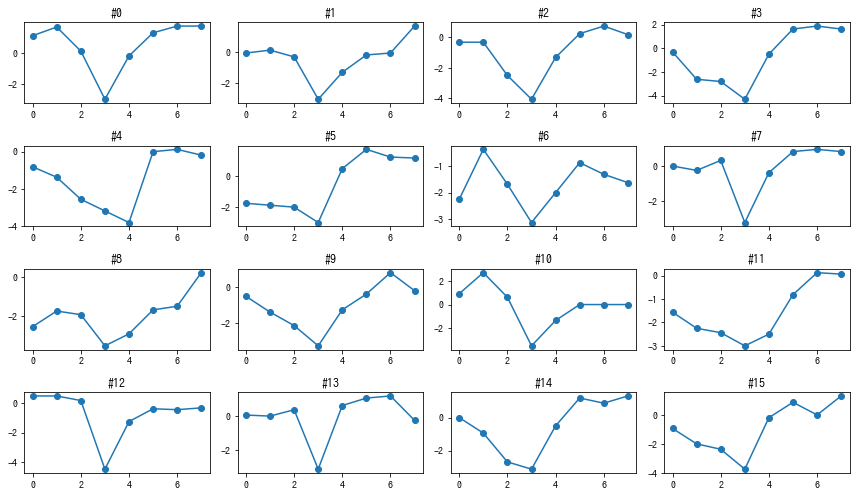

In [15]:
# ブレーキセグメント16個を試しにプロット
fig = plt.figure(figsize=(12,7))
for i, segment in enumerate(segment_list[:16]):
    ax = fig.add_subplot(4, 4, i+1)
    ax.plot(segment_list[i], "o-")
    plt.title(f"#{i}")
plt.tight_layout()

## K-means

In [214]:
segment_list_mini = segment_list[1:201] # 200個取り出す (1個目ははずす)

In [215]:
from sklearn.cluster import KMeans # kmeans用モジュール

In [216]:
df_segment_list_mini = pd.DataFrame(segment_list_mini, columns=[f"val{i}" for i in range(8)]) # dataframeに

In [217]:
df_segment_list_mini.head()

,val0,val1,val2,val3,val4,val5,val6,val7
0,-0.0625,0.1250,-0.3125,-3.0625,-1.3125,-0.1875,-0.0625,1.6875
1,-0.3125,-0.3125,-2.5000,-4.0625,-1.3125,0.2500,0.7500,0.1875
2,-0.3125,-2.6250,-2.8125,-4.3125,-0.5000,1.6250,1.8750,1.6250
3,-0.8125,-1.3750,-2.5625,-3.1875,-3.8125,0.0000,0.1250,-0.1875
4,-1.7500,-1.8750,-2.0000,-3.0000,0.5000,1.7500,1.2500,1.1875


In [220]:
df_segment_list_mini.dropna(inplace=True)

In [219]:
km = KMeans(n_clusters=4) # k-meansのインスタンス。クラスタ数は4に設定

In [221]:
km.fit(df_segment_list_mini.values) # k-meansを実行

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

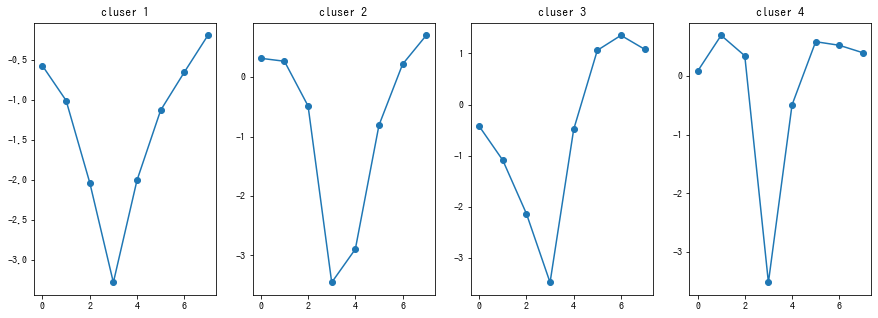

In [222]:
# plot center of each clusters
fig = plt.figure(figsize=(15,5))
for i, center in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(center, "o-")
    plt.title(f"cluser {i+1}")

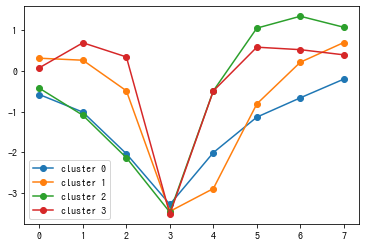

In [223]:
# plot center of each clusters
for i, center in enumerate(km.cluster_centers_):
    plt.plot(center, "o-", label=f"cluster {i}")
plt.legend()

In [224]:
df_segment_list_mini["cluster"] = km.predict(df_segment_list_mini) # 分類結果

In [225]:
cluster_tmp = df_segment_list_mini.loc[df_segment_list_mini.cluster==3].iloc[:8]

In [226]:
cluster_tmp.head()

,val0,val1,val2,val3,val4,val5,val6,val7,cluster
0,-0.0625,0.125,-0.3125,-3.0625,-1.3125,-0.1875,-0.0625,1.6875,3
6,0.0000,-0.250,0.3125,-3.1875,-0.3750,0.8125,0.9375,0.8125,3
9,0.9375,2.750,0.6250,-3.5625,-1.3750,0.0000,0.0000,0.0000,3
11,0.5000,0.500,0.1875,-4.5000,-1.2500,-0.3750,-0.4375,-0.3125,3
12,0.0625,0.000,0.3750,-3.1250,0.6250,1.0625,1.1875,-0.2500,3


In [242]:
df_segment_list_mini.loc[df_segment_list_mini.cluster==i].iloc[:,:8].reset_index(drop=True).T.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-0.0625,0.0000,0.9375,0.5000,0.0625,1.6250,-3.9375,-0.1250,-1.2500,0.500,...,-0.1250,0.0625,0.0000,0.2500,-0.1250,1.0000,0.0000,0.6250,1.1875,0.8125
1,0.1250,-0.2500,2.7500,0.5000,0.0000,1.2500,0.5000,0.0625,0.0000,-0.250,...,1.6250,-0.1250,2.4375,1.0625,-0.1875,1.5000,0.3125,1.1250,1.0000,1.4375
2,-0.3125,0.3125,0.6250,0.1875,0.3750,0.7500,1.2500,0.1250,-0.1250,-0.375,...,-0.7500,0.6875,0.7500,-0.6875,-0.0625,0.0000,-0.0625,1.1250,-0.1250,1.0000
3,-3.0625,-3.1875,-3.5625,-4.5000,-3.1250,-3.9375,-4.3125,-3.3125,-4.1875,-3.000,...,-4.3125,-3.0000,-3.2500,-3.3125,-3.3750,-3.0625,-4.0625,-3.3750,-3.0625,-4.2500
4,-1.3125,-0.3750,-1.3750,-1.2500,0.6250,0.5000,-0.2500,-1.1875,0.1875,-1.250,...,-0.2500,0.3750,-1.3750,-0.1250,-0.8750,-1.1875,0.0000,-1.2500,0.0000,1.5000
5,-0.1875,0.8125,0.0000,-0.3750,1.0625,1.2500,1.5000,0.2500,1.5000,0.875,...,0.0000,0.1250,0.1250,1.1250,0.0000,1.4375,1.6250,-1.2500,2.0000,2.0000
6,-0.0625,0.9375,0.0000,-0.4375,1.1875,-4.3125,1.6875,1.1875,1.2500,0.500,...,1.5000,0.0000,-0.1250,-0.1250,0.0625,2.0000,1.6875,-1.1250,0.3750,1.6875
7,1.6875,0.8125,0.0000,-0.3125,-0.2500,-0.2500,1.3750,1.1875,0.3750,2.000,...,1.5000,0.0625,0.2500,1.1875,0.0625,1.8125,0.6875,-0.0625,0.8125,-0.1250


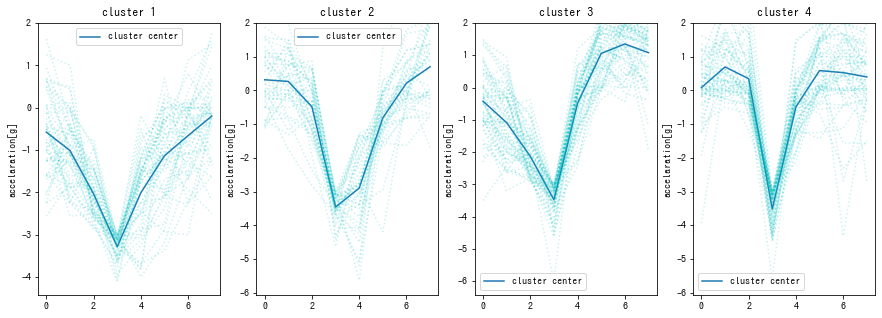

In [245]:
fig = plt.figure(figsize=(15,5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    # そのクラスタに分類されたを取り出す
    cluster_tmp = (df_segment_list_mini
                   .loc[df_segment_list_mini.cluster==i]
                   .iloc[:,:8]
                   .reset_index(drop=True)
                   .T.reset_index(drop=True))
    ax.plot(km.cluster_centers_[i], label="cluster center")  # クラスタの中心をplot
    ax.plot(cluster_tmp, "c:", alpha=0.2) # クラスタに分類された加速度たちをプロット
    ax.set_ylim(None,2) # 外れ値があったのでyのプロット範囲を限定
    ax.set_title(f"cluster {i+1}")
    ax.set_ylabel("accelaration[g]")
    ax.legend()

## 距離の計算

In [248]:
df_values_mini = df_segment_list_mini.iloc[:, :8]

In [261]:
euclidean(df_values_mini.iloc[0,:8], km.cluster_centers_[0])

3.1414967134277623

In [263]:
from scipy.spatial.distance import euclidean

for i in range(4):
    cluster_center = km.cluster_centers_[i]
    # クラスターiとのユークリッド距離
    df_segment_list_mini[f"distance_to_center{i}"] = \
        df_values_mini.apply(lambda x: euclidean(x, km.cluster_centers_[0]), axis=1)

In [265]:
df_segment_list_mini.head()

,val0,val1,val2,val3,val4,val5,val6,val7,cluster,distance_to_center0,distance_to_center1,distance_to_center2,distance_to_center3
0,-0.0625,0.1250,-0.3125,-3.0625,-1.3125,-0.1875,-0.0625,1.6875,3,3.141497,3.141497,3.141497,3.141497
1,-0.3125,-0.3125,-2.5000,-4.0625,-1.3125,0.2500,0.7500,0.1875,2,2.431722,2.431722,2.431722,2.431722
2,-0.3125,-2.6250,-2.8125,-4.3125,-0.5000,1.6250,1.8750,1.6250,2,4.895226,4.895226,4.895226,4.895226
3,-0.8125,-1.3750,-2.5625,-3.1875,-3.8125,0.0000,0.1250,-0.1875,0,2.372880,2.372880,2.372880,2.372880
4,-1.7500,-1.8750,-2.0000,-3.0000,0.5000,1.7500,1.2500,1.1875,2,4.729777,4.729777,4.729777,4.729777


## Appendix: LBG algorithm (Linde-Buzo-Gray algorithm)